# Descriptive Statistics and Tests

In [2]:
#performe standard imports and load datasets
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs
import pandas as pd
import numpy as np

%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load a seasonal dataset
df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

# Tests for Stationarity (Augmented Dickey-Fuller Test)

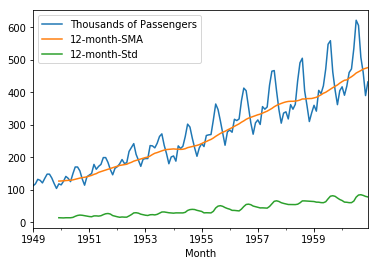

In [3]:
#plot the actual data from airline passengers and compare it with sma and rolling standard deviation

df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();

Not only is this dataset seasonal with a clear upward trend, the standard deviation increases over time as well

In [4]:
#apply augmented dickey fuller test and check the stationarity of data 
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df1['Thousands of Passengers'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(0.8153688792060433,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

To find out what these values represent we can run help(adfuller)

In [5]:
#print out the result of your statistic test
print('Augmented Dickey-Fuller Test on Airline Data')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Airline Data
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64


Here we have a very high p-value at 0.99, which provides weak evidence against the null hypothesis, and so we fail to reject the null hypothesis, and decide that our dataset is not stationary.

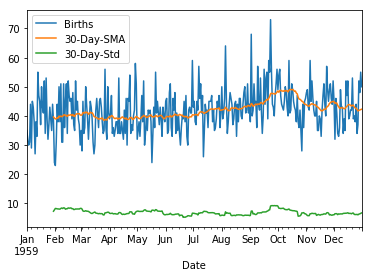

In [6]:
#Now let's apply the ADF test to stationary data with the Daily Total Female Births dataset
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()

df2[['Births','30-Day-SMA','30-Day-Std']].plot();

In [7]:
#print out the result of our statistic test
print('Augmented Dickey-Fuller Test on Daily Female Births')
dftest = adfuller(df2['Births'],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Daily Female Births
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
dtype: float64


In this case our p-value is very low at 0.000052, and we do reject the null hypothesis. This dataset appears to have no unit root, and is stationary.

# Function for running the augmented Dickey-Fuller test

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    print(result)
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Granger Causality Tests

The Granger causality test is a a hypothesis test to determine if one time series is useful in forecasting another.

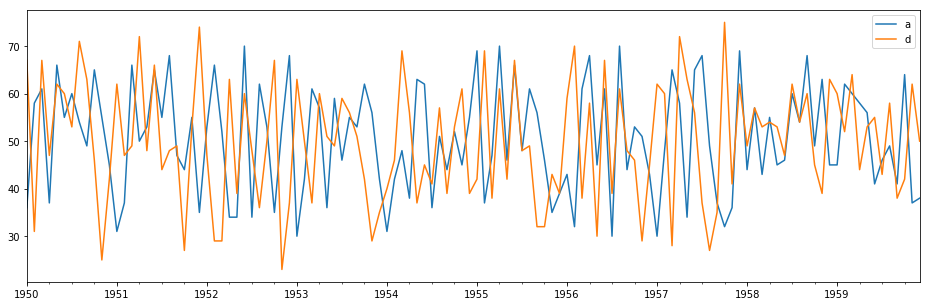

In [9]:
#import samples.csv and visualize the col a and d
df3 = pd.read_csv('samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'
df3[['a','d']].plot(figsize=(16,5));


The function takes in a 2D array [y,x] and a maximum number of lags to test on x. Here our y is column 'a' and x is column 'd'. We'll set maxlags to 3.

In [10]:
#Run the test to check any possible relationship between the cols
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


Essentially we're looking for extremely low p-values, which we see at lag 2.

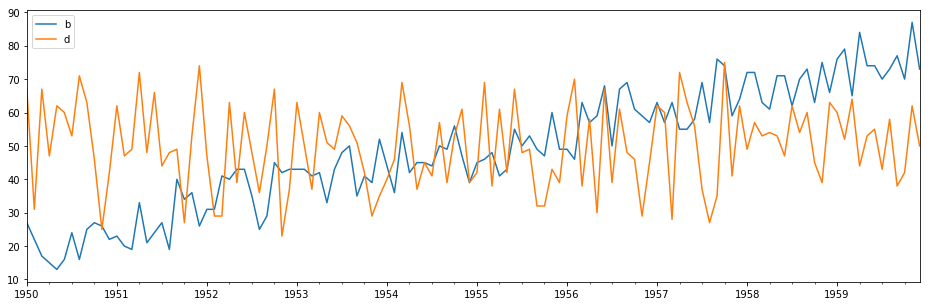

In [11]:
#Go ahead and check the same test for col b and d
df3[['b','d']].plot(figsize=(16,5));

In [83]:
#Run the statastical test
grangercausalitytests(df3[['b','d']],maxlag=6);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7084  , p=0.5879  

# Choosing ARIMA Orders

Before we can apply an ARIMA forecasting model, we need to review the components of one.
ARIMA, or Autoregressive Integration Moving Average is actually a combination of 3 models:

AR(p) Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.

I(d) Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary

MA(q) Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [1]:
#import libraries and datasets
import pandas as pd
import numpy as np
%matplotlib inline

# Load a non-stationary dataset
df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

# pmdarima Auto-ARIMA

In [2]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arim

We are going to use auto_arima library to find out ARIMA, ARMA,... orders

In [4]:
#lets look first at the stationary, non-seasonal daily female birth dataset
auto_arima(df2['Births'])

ARIMA(order=(1, 1, 1), scoring_args={}, with_intercept=False)

This shows a recommended (p,d,q) ARIMA Order of (1,1,1), with no seasonal_order component.

# ARMA(p,q) and ARIMA(p,d,q)

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df1 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv('TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

# Automate the augmented Dickey-Fuller Test

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Autoregressive Moving Average - ARMA(p,q)

In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the Daily Total Female Births dataset should work for our purposes.

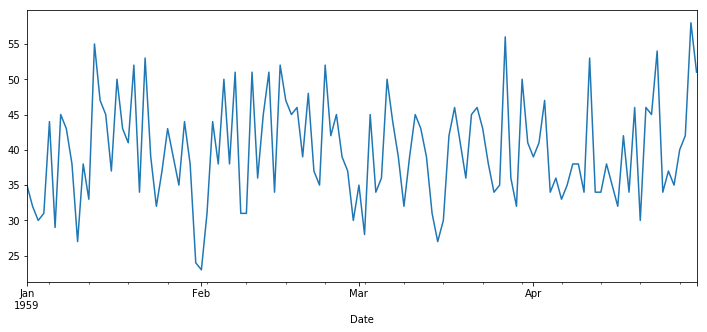

In [7]:
#plot the source data
df1['Births'].plot(figsize=(12,5));

In [8]:
#Run the augmented Dickey-Fuller Test to confirm stationarity
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [9]:
#Determine the (p,q) ARMA Orders using pmdarima.auto_arima
auto_arima(df1['Births'],seasonal=False)

ARIMA(order=(0, 0, 0), scoring_args={})

# Split the data into train/test sets

As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast

In [10]:
# Set one month for testing
train = df1.iloc[:90]
test = df1.iloc[90:]

# Fit an ARMA(p,q) Model

In [11]:
model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Mon, 07 Sep 2020   AIC                            627.809
Time:                        22:56:29   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.500      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.800      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.556      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
#prediction
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

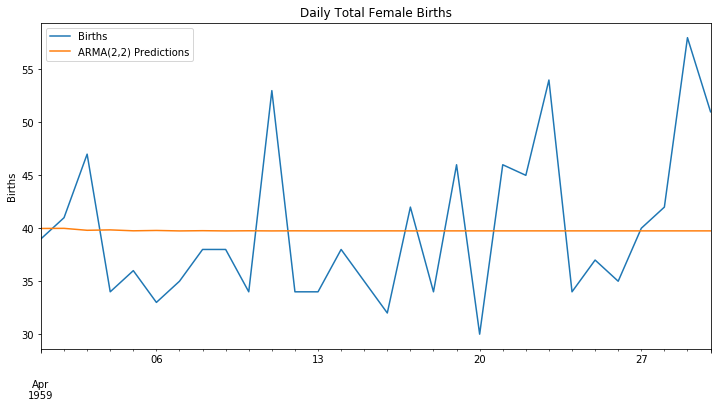

In [13]:
#Plot the prediction against known values
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. In the next section we'll take additional steps to evaluate the performance of our predictions, and forecast into the future.

# Autoregressive Integrated Moving Average - ARIMA(p,d,q)

The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.
First let's take a look at the Real Manufacturing and Trade Inventories dataset.

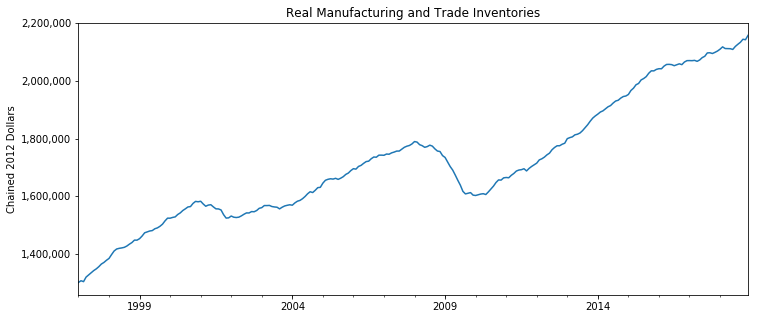

In [26]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Use pmdarima.auto_arima to determine ARIMA Orders

The correct order for p d and q is ARIMA (1,1,1)

In [109]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Fri, 04 Sep 2020   AIC                           5348.037
Time:                        14:33:30   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Split the data into train/test sets

In [28]:
len(df2)

264

In [29]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

# Fit an ARIMA(1,1,1) Model

In [30]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Fri, 04 Sep 2020   AIC                           4980.790
Time:                        10:55:44   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.870      2.378      0.017     561.674    5833.466
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

# prediction

In [31]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

Passing dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables.

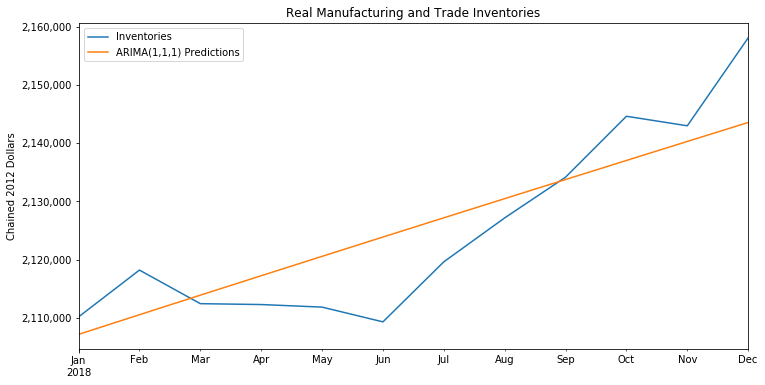

In [32]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Evaluate the Model

In [33]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 7789.597331


# Retrain the model on the full data, and forecast the future

In [34]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

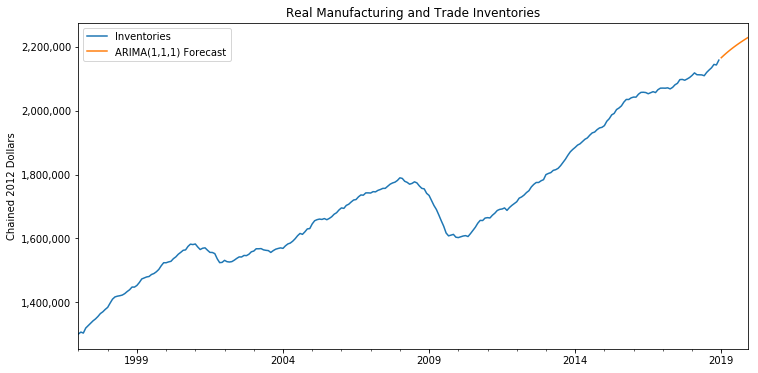

In [35]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# SARIMA(p,d,q)(P,D,Q)m

Where ARIMA accepts the parameters  (𝑝,𝑑,𝑞) , SARIMA accepts an additional set of parameters  (𝑃,𝐷,𝑄)𝑚  that specifically describe the seasonal components of the model. Here  𝑃 ,  𝐷  and  𝑄  represent the seasonal regression, differencing and moving average coefficients, and  𝑚  represents the number of data points (rows) in each seasonal cycle

# Perform standard imports and load datasets

In [36]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('co2_mm_mlo.csv')

In [37]:
#Inspect the data, create a DatetimeIndex
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [38]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [39]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


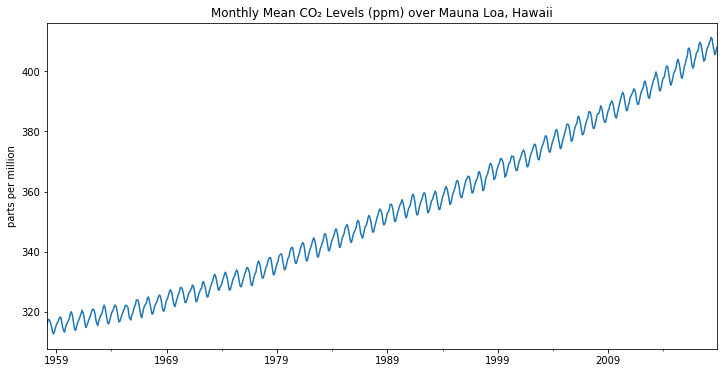

In [40]:
#Plot the source data
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

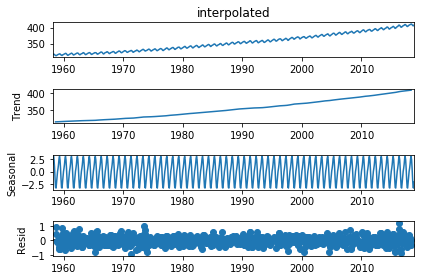

In [41]:
#Run an ETS Decomposition
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

small in scale compared to the overall values, there is a definite annual seasonality

SARIMAX(0, 1, 3)x(1, 0, 1, 12)

In [42]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.251
Date:                            Fri, 04 Sep 2020   AIC                            424.502
Time:                                    11:03:09   BIC                            452.044
Sample:                                         0   HQIC                           435.130
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3501      0.107      3.277      0.001       0.141       0.560
ar.L2          0.0870      0.056      1.541      0.123      -0.024       0.198
ma.L1         -0.7056      0.101     -6.992      0.000      -0.903      -0.508
ar.S.L12       0.9996      0.000   2976.750      0.000       0.999       1.000
ma.S.L12      -0.8669      0.021    -40.771      0.000      -0.909      -0.825
sigma2         0.0957      0.004     21.333      0.000       0.087       0.104
===================================================================================
Ljung-Box (Q):                       43.78   Jarque-Bera (JB):                 4.50
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Split the data into train/test sets and fit SARIMA

In [43]:
len(df)

729

In [44]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

In [45]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.191
Date:                              Fri, 04 Sep 2020   AIC                            414.381
Time:                                      11:03:13   BIC                            441.823
Sample:                                  03-01-1958   HQIC                           424.978
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3547      0.036     -9.975      0.000      -0.424      -0.285
ma.L2         -0.0237      0.037     -0.644      0.519      -0.096       0.048
ma.L3         -0.0872      0.035     -2.480      0.013      -0.156      -0.018
ar.S.L12       0.9997      0.000   3183.800      0.000       0.999       1.000
ma.S.L12      -0.8670      0.022    -38.821      0.000      -0.911      -0.823
sigma2         0.0949      0.005     20.359      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.93   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

Passing dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables.

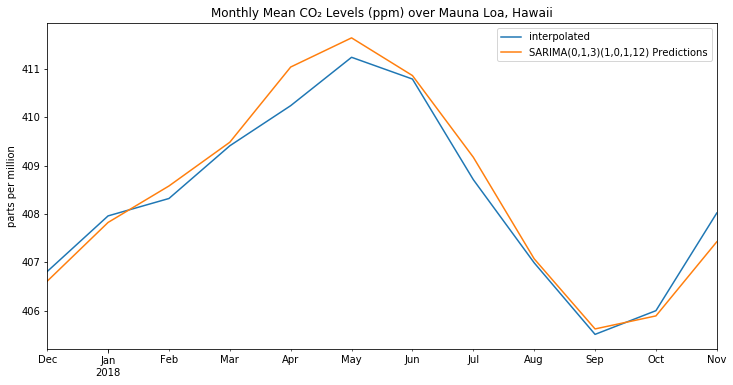

In [47]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Evaluate the Model

In [48]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3577116826


# Retrain the model on the full data, and forecast the future

In [49]:
model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

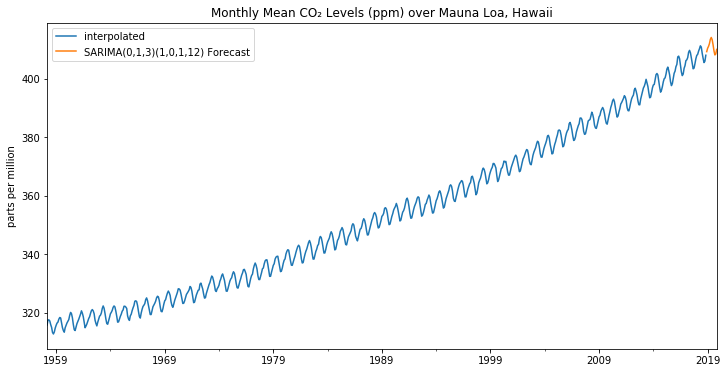

In [50]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Forecasting Exercises

In [111]:
# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


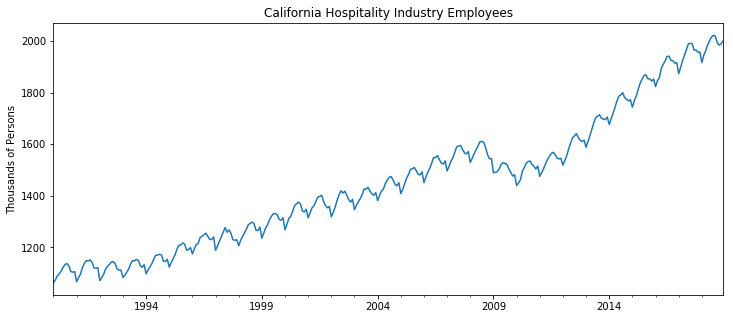

In [112]:
#1. Plot the source data
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel='' # we don't really need a label here

ax = df['Employees'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

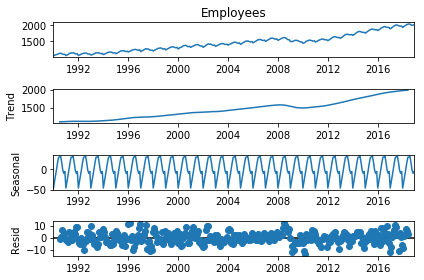

In [113]:
#2. Run an ETS Decomposition (use additive model)
result = seasonal_decompose(df['Employees'], model='add')
result.plot();

In [114]:
#3. Run pmdarima.auto_arima to obtain recommended (Correct order should be :orders SARIMAX(0, 1, 0)x(2, 0, 0, 12))

auto_arima(df['Employees'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Fri, 04 Sep 2020   AIC                           2208.504
Time:                                      15:30:37   BIC                           2231.600
Sample:                                           0   HQIC                          2217.700
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.524      0.000       0.836       1.013
ma.L1         -0.9440      0.069    -13.616      0.000      -1.080      -0.808
ma.L2          0.1288      0.060      2.163      0.031       0.012       0.245
ar.S.L12       0.9972      0.001    701.887      0.000       0.994       1.000
ma.S.L12      -0.7489      0.043    -17.329      0.000      -0.834      -0.664
sigma2        29.2996      1.717     17.063      0.000      25.934      32.665
===================================================================================
Ljung-Box (Q):                       31.48   Jarque-Bera (JB):                67.44
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
#4. Split the data into train/test sets
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [117]:
#6. Obtain predicted values
model = SARIMAX(train['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))
results = model.fit()
#results.summary()
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Predictions')


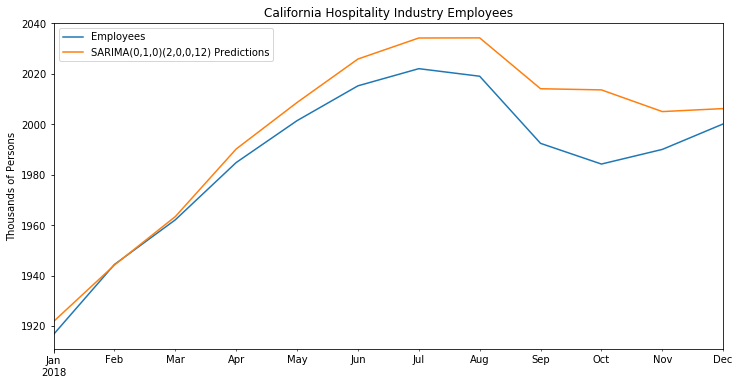

In [118]:
#7. Plot predictions against known values (ass title and y-axis lable)
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = test['Employees'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [119]:
#8. Evaluate the Model using RMSE

error2 = rmse(test['Employees'], predictions)

print(f'SARIMA(0,1,0)(2,0,0,12) RMSE Error: {error2:11.10}')

SARIMA(0,1,0)(2,0,0,12) RMSE Error: 13.52222828


In [120]:
#9. Retrain the model on the full data and forecast one year into the future

model = SARIMAX(df['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Forecast')

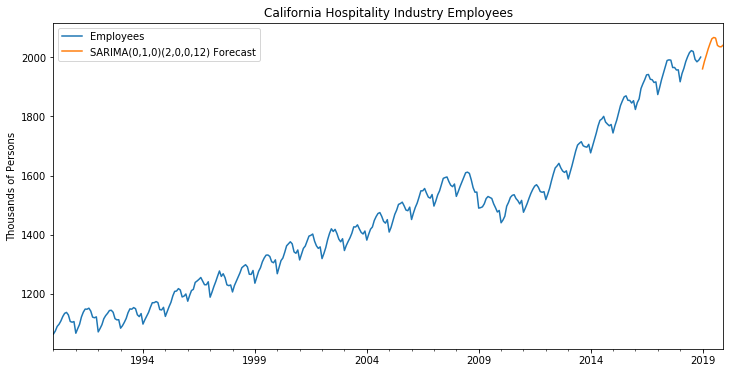

In [121]:
#10. Plot the forecasted values alongside the original data

title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Facebook Prophet Library

In [61]:
#Load Library
import pandas as pd
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [62]:
#Load Data
df = pd.read_csv('BeerWineLiquor.csv')

In [63]:
df.head()

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


In [80]:
df.tail()

,ds,y
319,2018-08-01,4898
320,2018-09-01,4598
321,2018-10-01,4737
322,2018-11-01,5130
323,2018-12-01,6370


In [81]:
df.head()

,ds,y
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822


In [64]:
#Format the Data

df.columns = ['ds','y']

In [65]:
df['ds'] = pd.to_datetime(df['ds'])

# Create and Fit Model

In [66]:
# This is fitting on all the data (no train test split in this example)
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forecasting

# Step 1: Create "future" placeholder dataframe
NOTE: Prophet by default is for daily data. You need to pass a frequency for sub-daily or monthly data.

In [67]:
future = m.make_future_dataframe(periods=24,freq = 'MS')

In [68]:
df.tail()

,ds,y
319,2018-08-01,4898
320,2018-09-01,4598
321,2018-10-01,4737
322,2018-11-01,5130
323,2018-12-01,6370


In [69]:
future.tail()

,ds
343,2020-08-01
344,2020-09-01
345,2020-10-01
346,2020-11-01
347,2020-12-01


In [70]:
len(df)

324

In [71]:
len(future)

348

# Step 2: Predict and fill in the Future

In [72]:
forecast = m.predict(future)

In [73]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,1771.312291,1152.543939,1474.682471,1771.312291,1771.312291,-461.653037,-461.653037,-461.653037,-461.653037,-461.653037,-461.653037,0.0,0.0,0.0,1309.659254
1,1992-02-01,1774.175336,1180.964363,1507.436215,1774.175336,1774.175336,-427.115870,-427.115870,-427.115870,-427.115870,-427.115870,-427.115870,0.0,0.0,0.0,1347.059466
2,1992-03-01,1776.853668,1438.137252,1757.142883,1776.853668,1776.853668,-178.790756,-178.790756,-178.790756,-178.790756,-178.790756,-178.790756,0.0,0.0,0.0,1598.062912
3,1992-04-01,1779.716713,1413.522482,1753.565088,1779.716713,1779.716713,-196.311692,-196.311692,-196.311692,-196.311692,-196.311692,-196.311692,0.0,0.0,0.0,1583.405020
4,1992-05-01,1782.487401,1667.317364,1996.582657,1782.487401,1782.487401,44.675263,44.675263,44.675263,44.675263,44.675263,44.675263,0.0,0.0,0.0,1827.162664


In [74]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
343,2020-08-01,5200.823239,5080.469380,5401.735965,5188.828113,5211.810352,39.703050,39.703050,39.703050,39.703050,39.703050,39.703050,0.0,0.0,0.0,5240.526290
344,2020-09-01,5216.882602,4930.701496,5259.053475,5204.092588,5228.575788,-133.367528,-133.367528,-133.367528,-133.367528,-133.367528,-133.367528,0.0,0.0,0.0,5083.515075
345,2020-10-01,5232.423922,5009.632410,5353.913377,5218.810602,5245.106004,-43.400195,-43.400195,-43.400195,-43.400195,-43.400195,-43.400195,0.0,0.0,0.0,5189.023726
346,2020-11-01,5248.483285,5178.138154,5503.912272,5233.714893,5261.993025,86.835312,86.835312,86.835312,86.835312,86.835312,86.835312,0.0,0.0,0.0,5335.318596
347,2020-12-01,5264.024604,6180.885379,6502.607049,5248.173529,5278.292538,1071.135334,1071.135334,1071.135334,1071.135334,1071.135334,1071.135334,0.0,0.0,0.0,6335.159938


In [75]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [76]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
336,2020-01-01,4628.826837,4460.701129,4801.593789
337,2020-02-01,4679.423367,4513.433648,4843.484684
338,2020-03-01,4942.771756,4779.562373,5107.252483
339,2020-04-01,4941.310183,4785.916116,5105.205568
340,2020-05-01,5197.838458,5038.191411,5361.299581
341,2020-06-01,5178.810228,5012.635769,5336.141400
342,2020-07-01,5311.203177,5153.036668,5456.746460
343,2020-08-01,5240.526290,5080.469380,5401.735965
344,2020-09-01,5083.515075,4930.701496,5259.053475
345,2020-10-01,5189.023726,5009.632410,5353.913377


# Plotting Forecast

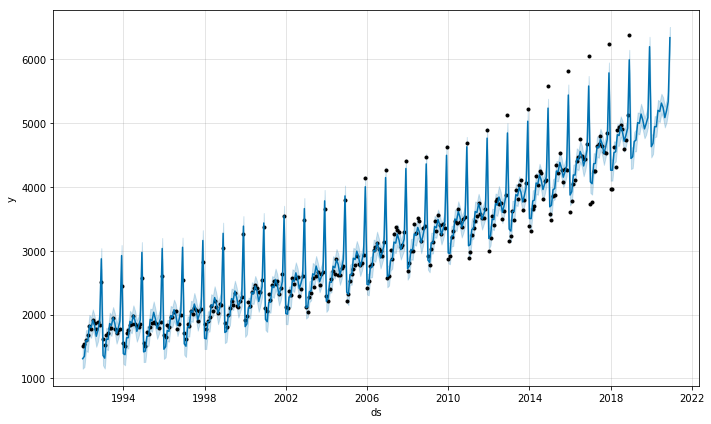

In [77]:
m.plot(forecast);

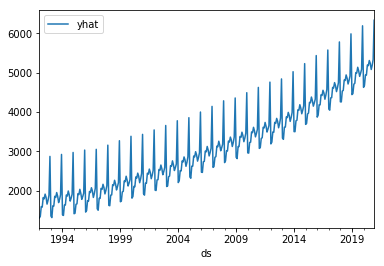

In [78]:
forecast.plot(x='ds',y='yhat')

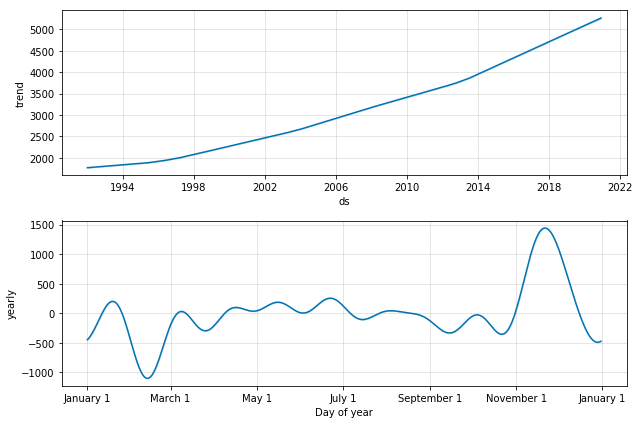

In [79]:
m.plot_components(forecast);